In [11]:
!git clone https://github.com/JovanK26/EpiInfer.git

fatal: destination path 'EpiInfer' already exists and is not an empty directory.


In [12]:
"""
Epidemic Forecasting Model Comparison
Compares EpiInfer (compartmental) and ARIMA models
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Model parameters
INCUBATION_PERIOD = 7
FORECAST_DAYS = 5
NUM_COMPARTMENTS = 4  # S, E, I, R
NUM_GROUPS = 6
RECOVERY_RATE = 0.1
IMMUNITY_LOSS_RATE = 0.01

# Population data
AUSTRIA_POPULATION = 8_913_088
POPULATION_GROUPS = [0.887, 0.076, 0.019, 0.011, 0.004, 0.003]
CONTACTS_PER_GROUP = np.array([3, 8, 15, 35, 75, 100])

# Data paths
DATA_DIR = "EpiInfer/Data"
COUNTRY = "AT_"

# ARIMA parameters
ARIMA_ORDER = (5, 1, 2)  # (p, d, q)

## Main Logic

In [14]:
# =============================================================================
# DATA INITIALIZATION
# =============================================================================

def initialize_population():
    """Initialize population arrays by contact group."""
    pop = np.zeros(NUM_GROUPS + 1)
    pop[0] = AUSTRIA_POPULATION
    for i in range(NUM_GROUPS):
        pop[i + 1] = AUSTRIA_POPULATION * POPULATION_GROUPS[i]
    return pop

def load_data(total_days):
    """Load epidemic data from CSV files."""
    data_dir = Path(DATA_DIR)
    cum_file = data_dir / f"{COUNTRY}datacumu.csv"
    daily_file = data_dir / f"{COUNTRY}datanew.csv"

    cum_df = pd.read_csv(cum_file, header=None)
    daily_df = pd.read_csv(daily_file, header=None)

    days = min(len(cum_df), total_days)

    # Initialize arrays: (day, compartment, group)
    cum_real = np.zeros((days, NUM_COMPARTMENTS, NUM_GROUPS + 1))
    daily_real = np.zeros((days, NUM_COMPARTMENTS, NUM_GROUPS + 1))

    # Load data
    for d in range(days):
        for c in range(min(cum_df.shape[1], NUM_COMPARTMENTS)):
            cum_real[d, c, 0] = cum_df.iloc[d, c]
            daily_real[d, c, 0] = daily_df.iloc[d, c]

            # Distribute across groups
            for g in range(NUM_GROUPS):
                cum_real[d, c, g + 1] = cum_real[d, c, 0] * POPULATION_GROUPS[g]
                daily_real[d, c, g + 1] = daily_real[d, c, 0] * POPULATION_GROUPS[g]

    return cum_real, daily_real, days

# =============================================================================
# EPIINFER MODEL (formerly SEIR)
# =============================================================================

def simulate_epiinfer(population, cum_real, daily_real, p1, p2, train_end):
    """Run EpiInfer epidemic simulation."""
    days = len(cum_real)
    cum_sim = np.zeros_like(cum_real)
    daily_sim = np.zeros_like(daily_real)

    # Initialize with real data
    cum_sim[:INCUBATION_PERIOD] = cum_real[:INCUBATION_PERIOD]
    daily_sim[:INCUBATION_PERIOD] = daily_real[:INCUBATION_PERIOD]

    for day in range(INCUBATION_PERIOD, days):
        simulate_day(day, population, cum_real, daily_real, cum_sim,
                    daily_sim, p1, p2, train_end)

    return cum_sim, daily_sim

def simulate_day(day, pop, cum_real, daily_real, cum_sim, daily_sim, p1, p2, train_end):
    """Simulate single day of epidemic."""
    inc = INCUBATION_PERIOD
    ng = NUM_GROUPS + 1

    # Calculate recent infections (past week)
    recent_inf = np.zeros(ng)
    for lag in range(1, inc + 1):
        if day - lag >= 0:
            data_source = daily_sim if day - lag >= train_end else daily_real
            recent_inf += data_source[day - lag, 2, :]

    # Get infected at t - incubation_period
    data_source = cum_sim if day - inc >= train_end else cum_real
    total_inf = data_source[day - inc, 2, :]

    asymptomatic = pop - total_inf

    # Calculate exposure and transmission probabilities
    p_exposure = recent_inf[0] / (p2 * asymptomatic[0])
    p_trans = np.ones(ng)
    for g in range(1, ng):
        p_trans[g] = 1 - (1 - p1) ** (CONTACTS_PER_GROUP[g - 1] * p_exposure)

    # Calculate susceptible population
    susceptible = asymptomatic - recent_inf / p2 - cum_sim[day - inc, 3, :]
    susceptible[1:] = np.maximum(susceptible[1:], 0)

    # New exposures
    new_exposed = np.zeros(ng)
    new_exposed[1:] = susceptible[1:] * p_trans[1:]
    new_exposed[0] = new_exposed[1:].sum()

    # Record with incubation delay
    if day - inc >= inc:
        daily_sim[day - inc, 1, :] = new_exposed

    # New infections, recoveries, immunity loss
    daily_sim[day, 2, :] = new_exposed * p2
    daily_sim[day, 3, :] = cum_sim[day - 1, 2, :] * RECOVERY_RATE
    daily_sim[day, 0, :] = cum_sim[day - 1, 3, :] * IMMUNITY_LOSS_RATE

    # Update cumulative counts
    cum_sim[day, 3, :] = cum_sim[day - 1, 3, :] - daily_sim[day, 0, :] + daily_sim[day, 3, :]
    cum_sim[day, 2, :] = cum_sim[day - 1, 2, :] + daily_sim[day, 2, :] - daily_sim[day, 3, :]

def optimize_parameters(pop, cum_real, daily_real, train_end):
    """Optimize p1 and p2 parameters using grid + binary search."""
    best_p1, best_p2, best_rmse = -1, -1, np.inf

    # Grid search over p2
    for p2 in np.linspace(0.1, 1.0, 10):
        # Binary search for p1
        left, right = 0.0, 1.0

        while right - left > 0.0001:
            p1 = (left + right) / 2
            cum_sim, daily_sim = simulate_epiinfer(pop, cum_real, daily_real, p1, p2, train_end)

            # Calculate residual at last training day
            residual = cum_sim[train_end - 1, 2, 0] - cum_real[train_end - 1, 2, 0]
            rmse = np.sqrt(residual ** 2)

            if rmse < best_rmse:
                best_p1, best_p2, best_rmse = p1, p2, rmse

            # Adjust search range
            if residual < 0:
                left = p1
            elif residual > 0:
                right = p1
            else:
                break

    return best_p1, best_p2

# =============================================================================
# ARIMA MODEL
# =============================================================================

def forecast_arima(cum_real, train_end, forecast_days):
    """Forecast using ARIMA model."""
    try:
        # Extract training data (cumulative infected)
        train_data = cum_real[:train_end, 2, 0]

        # Fit ARIMA model
        model = ARIMA(train_data, order=ARIMA_ORDER)
        fitted_model = model.fit()

        # Forecast
        forecast = fitted_model.forecast(steps=forecast_days)

        # Create full prediction array
        predictions = np.zeros(len(cum_real))
        predictions[:train_end] = train_data
        predictions[train_end:train_end + forecast_days] = forecast

        return predictions, True
    except Exception as e:
        print(f"ARIMA failed: {e}")
        return np.zeros(len(cum_real)), False

# =============================================================================
# FORECASTING EXPERIMENT
# =============================================================================

def run_forecast_experiment(train_days_range, forecast_days=10):
    """Run forecasting across different training periods for all models."""
    results = []
    pop = initialize_population()

    for train_days in train_days_range:
        total_days = train_days + forecast_days + 1

        # Load data
        cum_real, daily_real, max_days = load_data(total_days)
        if max_days < total_days:
            continue

        train_end = total_days - forecast_days

        # ===== EpiInfer Model =====
        p1, p2 = optimize_parameters(pop, cum_real, daily_real, train_end)
        cum_epiinfer, _ = simulate_epiinfer(pop, cum_real, daily_real, p1, p2, train_end)

        # ===== ARIMA Model =====
        arima_pred, arima_success = forecast_arima(cum_real, train_end, forecast_days)

        # Calculate metrics
        pred_day = total_days - 1
        real_cases = cum_real[pred_day, 2, 0]

        epiinfer_cases = cum_epiinfer[pred_day, 2, 0]
        epiinfer_error = abs(epiinfer_cases - real_cases) / real_cases if real_cases > 0 else 0

        arima_cases = arima_pred[pred_day] if arima_success else 0
        arima_error = abs(arima_cases - real_cases) / real_cases if arima_success and real_cases > 0 else np.nan

        results.append({
            'train_days': train_days,
            'forecast_day': pred_day,
            'actual': real_cases,
            'epiinfer_pred': epiinfer_cases,
            'epiinfer_error': epiinfer_error,
            'arima_pred': arima_cases,
            'arima_error': arima_error,
            'p1': p1,
            'p2': p2
        })

        print(f"Train: {train_days:2d} | Actual: {real_cases:,.0f} | "
              f"EpiInfer: {epiinfer_cases:,.0f} ({epiinfer_error:.4f}) | "
              f"ARIMA: {arima_cases:,.0f} ({arima_error:.4f})")

    return pd.DataFrame(results)

# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_comparison_results(results_df):
    """Create comprehensive comparison visualization."""
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # 1. Predicted vs Actual Cases (All Models)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(results_df['forecast_day'], results_df['actual'],
             'k-', label='Actual', linewidth=2.5, marker='o', markersize=5)
    ax1.plot(results_df['forecast_day'], results_df['epiinfer_pred'],
             'b--', label='EpiInfer', linewidth=2, marker='s', markersize=4)
    ax1.plot(results_df['forecast_day'], results_df['arima_pred'],
             'g--', label='ARIMA', linewidth=2, marker='^', markersize=4)
    ax1.set_xlabel('Forecast Day', fontsize=12)
    ax1.set_ylabel('Cumulative Cases', fontsize=12)
    ax1.set_title('Model Predictions vs Actual Cases', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(alpha=0.3)
    ax1.ticklabel_format(style='plain', axis='y')

    # 2. Relative Error Comparison
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(results_df['train_days'], results_df['epiinfer_error'],
             'b-o', label='EpiInfer', markersize=5, linewidth=2)
    ax2.plot(results_df['train_days'], results_df['arima_error'],
             'g-s', label='ARIMA', markersize=5, linewidth=2)
    ax2.set_xlabel('Training Days', fontsize=11)
    ax2.set_ylabel('Relative Error', fontsize=11)
    ax2.set_title('Relative Error vs Training Period', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)

    # 3. Average Error by Model (Bar Chart)
    ax3 = fig.add_subplot(gs[1, 1])
    models = ['EpiInfer', 'ARIMA']
    avg_errors = [
        results_df['epiinfer_error'].mean(),
        results_df['arima_error'].mean()
    ]
    colors = ['#3498db', '#2ecc71']
    bars = ax3.bar(models, avg_errors, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.set_ylabel('Average Relative Error', fontsize=11)
    ax3.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, val in zip(bars, avg_errors):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 4. Error Distribution Comparison
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.hist(results_df['epiinfer_error'], bins=20, alpha=0.6,
             label='EpiInfer', color='blue', edgecolor='black')
    ax4.hist(results_df['arima_error'].dropna(), bins=20, alpha=0.6,
             label='ARIMA', color='green', edgecolor='black')
    ax4.axvline(results_df['epiinfer_error'].mean(), color='blue',
                linestyle='--', linewidth=2, label=f"EpiInfer Mean: {results_df['epiinfer_error'].mean():.4f}")
    ax4.axvline(results_df['arima_error'].mean(), color='green',
                linestyle='--', linewidth=2, label=f"ARIMA Mean: {results_df['arima_error'].mean():.4f}")
    ax4.set_xlabel('Relative Error', fontsize=11)
    ax4.set_ylabel('Frequency', fontsize=11)
    ax4.set_title('Error Distribution', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(alpha=0.3, axis='y')

    plt.savefig('epidemic_models_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Execution

EPIDEMIC FORECASTING MODEL COMPARISON
EpiInfer (Compartmental) vs ARIMA

Population: 8,913,088
Forecast horizon: 5 days
Training range: 10-90 days

Running forecasting experiment...

Train: 10 | Actual: 248 | EpiInfer: 231 (0.0677) | ARIMA: 160 (0.3541)
Train: 11 | Actual: 320 | EpiInfer: 267 (0.1654) | ARIMA: 236 (0.2629)
Train: 12 | Actual: 470 | EpiInfer: 305 (0.3517) | ARIMA: 192 (0.5919)
Train: 13 | Actual: 633 | EpiInfer: 296 (0.5325) | ARIMA: 136 (0.7849)
Train: 14 | Actual: 768 | EpiInfer: 402 (0.4769) | ARIMA: 288 (0.6250)
Train: 15 | Actual: 917 | EpiInfer: 694 (0.2436) | ARIMA: 732 (0.2017)
Train: 16 | Actual: 1,172 | EpiInfer: 885 (0.2449) | ARIMA: 515 (0.5607)
Train: 17 | Actual: 1,426 | EpiInfer: 1,361 (0.0459) | ARIMA: 1,275 (0.1063)
Train: 18 | Actual: 1,739 | EpiInfer: 1,840 (0.0580) | ARIMA: 1,660 (0.0450)
Train: 19 | Actual: 2,076 | EpiInfer: 2,110 (0.0165) | ARIMA: 1,568 (0.2446)
Train: 20 | Actual: 2,414 | EpiInfer: 2,349 (0.0270) | ARIMA: 1,348 (0.4416)
Train: 21 

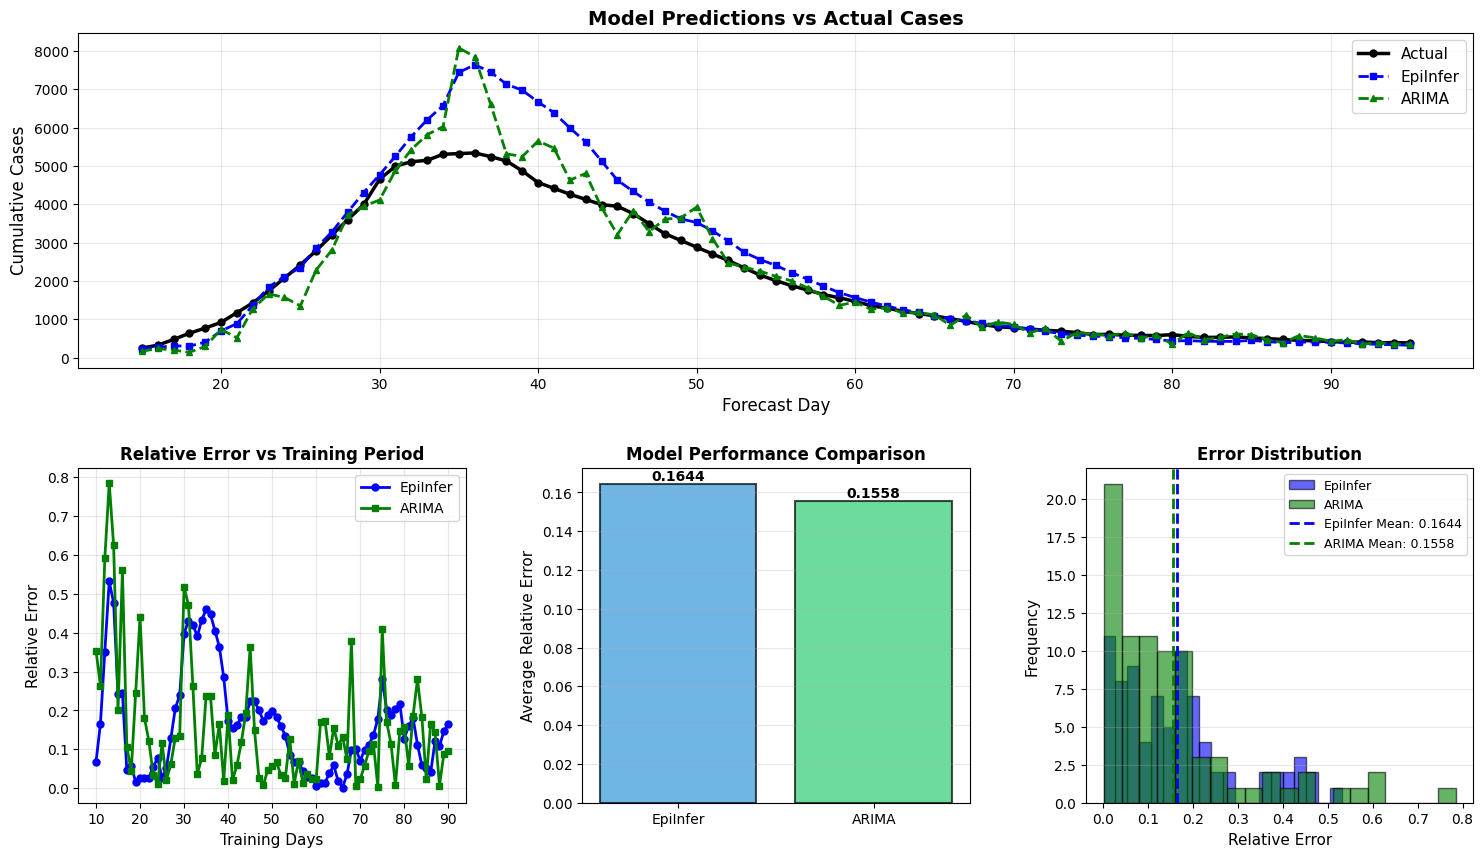

✓ Plots saved to 'epidemic_models_comparison.png'

BEST MODEL: ARIMA (Avg Error: 0.1558)

✓ Results saved to 'epidemic_models_comparison.csv'
✓ Generating comparison plots...


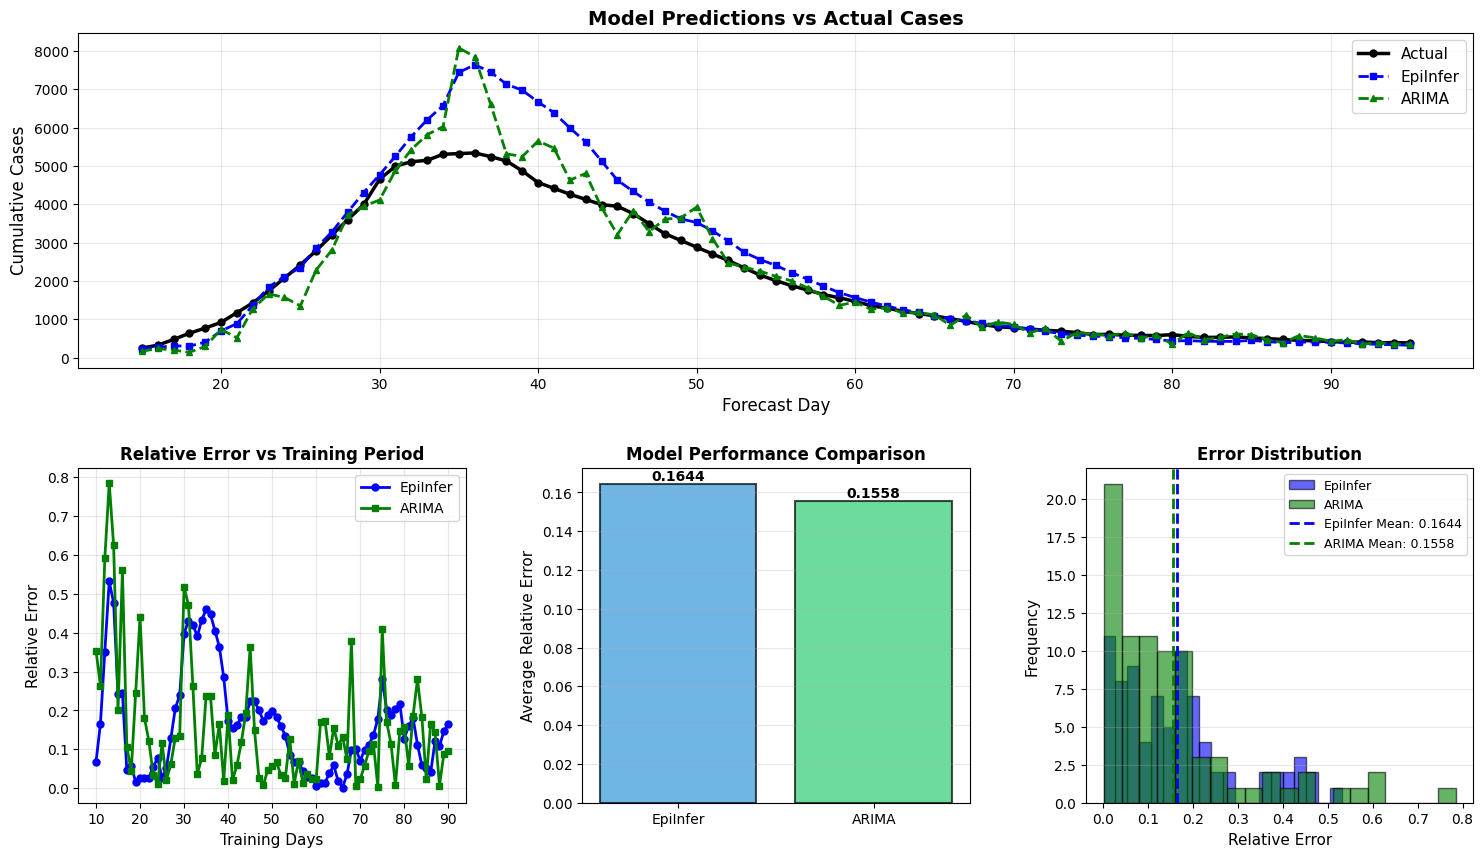

✓ Plots saved to 'epidemic_models_comparison.png'


In [15]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("="*80)
    print("EPIDEMIC FORECASTING MODEL COMPARISON")
    print("EpiInfer (Compartmental) vs ARIMA")
    print("="*80)

    # Setup
    print(f"\nPopulation: {AUSTRIA_POPULATION:,}")
    print(f"Forecast horizon: {FORECAST_DAYS} days")
    print(f"Training range: 10-90 days\n")

    # Run experiment
    print("Running forecasting experiment...\n")
    results_df = run_forecast_experiment(range(10, 91), FORECAST_DAYS)

    # Summary statistics
    print("\n" + "="*80)
    print("RESULTS SUMMARY")
    print("="*80)
    print(f"Experiments run: {len(results_df)}")

    print("\n--- EpiInfer Model ---")
    print(f"Avg relative error: {results_df['epiinfer_error'].mean():.4f}")
    print(f"Std relative error: {results_df['epiinfer_error'].std():.4f}")
    print(f"Min relative error: {results_df['epiinfer_error'].min():.4f}")
    print(f"Max relative error: {results_df['epiinfer_error'].max():.4f}")

    print("\n--- ARIMA Model ---")
    print(f"Avg relative error: {results_df['arima_error'].mean():.4f}")
    print(f"Std relative error: {results_df['arima_error'].std():.4f}")
    print(f"Min relative error: {results_df['arima_error'].min():.4f}")
    print(f"Max relative error: {results_df['arima_error'].max():.4f}")

    # Determine best model
    avg_errors = {
        'EpiInfer': results_df['epiinfer_error'].mean(),
        'ARIMA': results_df['arima_error'].mean()
    }
    best_model = min(avg_errors, key=avg_errors.get)

    print("\n" + "="*80)
    print(f"BEST MODEL: {best_model} (Avg Error: {avg_errors[best_model]:.4f})")
    print("="*80)

    # Save results
    results_df.to_csv('epidemic_models_comparison.csv', index=False)
    print("\n✓ Results saved to 'epidemic_models_comparison.csv'")

    # Visualize
    print("✓ Generating comparison plots...")
    plot_comparison_results(results_df)
    print("✓ Plots saved to 'epidemic_models_comparison.png'")
    print("\n" + "="*80)
    print(f"BEST MODEL: {best_model} (Avg Error: {avg_errors[best_model]:.4f})")
    print("="*80)

    # Save results
    results_df.to_csv('epidemic_models_comparison.csv', index=False)
    print("\n✓ Results saved to 'epidemic_models_comparison.csv'")

    # Visualize
    print("✓ Generating comparison plots...")
    plot_comparison_results(results_df)
    print("✓ Plots saved to 'epidemic_models_comparison.png'")